<a href="https://colab.research.google.com/github/technologyhamed/Apache-PySpark/blob/main/Churn_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

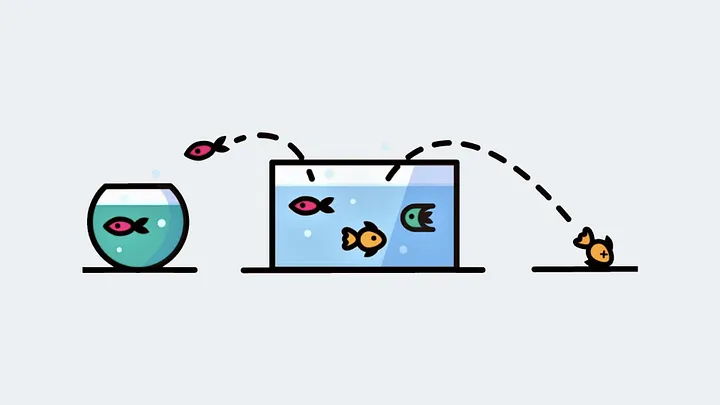

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Sparkify_Project") \
    .getOrCreate()

In [ ]:
path = "/content/Dataset/mini_sparkify_event_data.json"
data = spark.read.json(path)

**Data Exploration and Cleaning**

We can see that dataset contains a few fields identifying the user (userId, firstName, lastName, gender, location) and fields connected to the activities of users (artist, auth, page etc.).

The most interesting fields from the perspective of prediction model creation are:

userId — we will use this fields as our key
page — this field defines type of action
ts — timestamp of action

In [ ]:
data.printSchema()

In [ ]:
data \
  .filter(data.userId == "10") \
  .select("userId", "page", "ts", "song", "artist", "level")\
  .orderBy("ts")\
  .show(5)

Let’s also look what different actions can be made by user:

In [ ]:
import pyspark.sql.functions as F
data.groupBy("page").count().orderBy(F.desc("count")).show()

In [ ]:
data.describe("userId", "sessionId", "page", "ts").show()

In [ ]:
data_valid = (
    data.
    dropna(how = "any", subset = ["userId"]).
    filter(data["userId"] != "").
    withColumn("ts", F.from_unixtime(data.ts / 1000.0, "yyyy-MM-dd HH:mm:ss"))
)

**Features Engineering**

To create model for predicting churn, first we need to identify users in our dataset who cancelled their subscription. We can do this by tagging users with “Cancellation Confirmation” action:

In [ ]:
users_churn = (
    data_valid.
    filter(data_valid.page == "Cancellation Confirmation").
    select("userId").
    distinct().
    withColumn("cancelled", F.lit("1"))
)

By joining the list of users who cancelled their subscription to our main dataset we can create labels:

In [ ]:
data_labels = (
    data_valid.
    join(users_churn, ["userId"], "left").
    withColumn("cancelled", F.when(F.col("cancelled") == "1", "1").otherwise("0"))
)

In next step, based on our dataset, we need to create features which could be used to train our model.

By analyzing different interactions users can make I came up with fallowing features:

total time on a paid version
time on a paid or free version
number of songs played
number of Thumbs Down
number of Roll Advert
number of Add to Playlist
number of Add Friend
number of Thumbs Up
number of Errors

In [ ]:
from pyspark.sql.window import Window

# Total time on paid version / whole
user_window_desc = Window \
    .partitionBy('userID') \
    .orderBy(F.col('ts').desc())

user_window_asc = Window \
    .partitionBy('userID') \
    .orderBy(F.col('ts'))

time_on_paid_version = (
    data_labels.
    filter(F.col("level") == "paid").
    withColumn("beggining_ts", F.first("ts").over(user_window_asc)).
    withColumn("end_ts", F.first("ts").over(user_window_desc)).
    withColumn("time_on_paid_version", F.unix_timestamp("end_ts") - F.unix_timestamp("beggining_ts")).
    select("userId", "time_on_paid_version").
    distinct().
    withColumn("time_on_paid_version", F.when(F.col("time_on_paid_version").isNull(), 0).otherwise(F.col("time_on_paid_version")))
)

time_whole = (
    data_labels.
    withColumn("beggining_ts", F.first("ts").over(user_window_asc)).
    withColumn("end_ts", F.first("ts").over(user_window_desc)).
    withColumn("time_whole", F.unix_timestamp("end_ts") - F.unix_timestamp("beggining_ts")).
    select("userId", "time_whole").
    distinct()
)

# Other features:

data_features = (
    data_labels.
    groupBy("userId").
    agg(
        F.count(F.when(F.col("page") == "NextSong", True)).alias("number_of_songs_played"),
        F.count(F.when(F.col("page") == "Thumbs Down", True)).alias("number_of_thumbs_down"),
        F.count(F.when(F.col("page") == "Thumbs Up", True)).alias("number_of_thumbs_up"),
        F.count(F.when(F.col("page") == "Roll Advert", True)).alias("number_of_roll_advert"),
        F.count(F.when(F.col("page") == "Add to Playlist", True)).alias("number_of_add_to_playlist"),
        F.count(F.when(F.col("page") == "Add Friend", True)).alias("number_of_add_friend"),
        F.count(F.when(F.col("page") == "Error", True)).alias("number_of_errors"),
        F.first("cancelled").alias("label")
    ).
    join(time_on_paid_version, ["userId"], "left").
    withColumn("time_on_paid_version", F.when(F.col("time_on_paid_version").isNull(), 0).otherwise(F.col("time_on_paid_version"))).
    join(time_whole, ["userId"], "left")
)

Now we have aggregated dataframe were each row represents one user. We have 9 different features and label column. We are ready to build and train our model.

Modeling
Now we can move on to creating and optimizing machine learning model for churn prediction.

Firstly lest’s wrap up our feature columns into vector with help of VectorAssembler() :

In [ ]:
from pyspark.ml.feature import VectorAssembler
numericCols = ['number_of_songs_played', 'number_of_thumbs_down', 'number_of_thumbs_up', 'number_of_roll_advert', 'number_of_add_to_playlist', 'number_of_add_friend', 'number_of_errors', 'time_on_paid_version', 'time_whole']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
df_assembled = assembler.transform(data_features)

We can also apply StringIndexer() to our labels:

In [ ]:
from pyspark.ml.feature import StringIndexer
label_stringIdx = StringIndexer(inputCol = 'label', outputCol = 'labelIndex')
df_final = label_stringIdx.fit(df_assembled).transform(df_assembled)

Now we can create our training and test sets:


In [ ]:
train, test = df_final.randomSplit([0.7, 0.3], seed=42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
def print_metrics_(predictions):
    true_positives = predictions.select("labelIndex", "prediction").filter((F.col("labelIndex") == 1.0) & (F.col("prediction") == 1.0)).count()
    true_negatives = predictions.select("labelIndex", "prediction").filter((F.col("labelIndex") == 0.0) & (F.col("prediction") == 0.0)).count()
    false_positives = predictions.select("labelIndex", "prediction").filter((F.col("labelIndex") == 0.0) & (F.col("prediction") == 1.0)).count()
    false_negatives = predictions.select("labelIndex", "prediction").filter((F.col("labelIndex") == 1.0) & (F.col("prediction") == 0.0)).count()

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    print("Accuracy: ", accuracy)
    precision = true_positives / (true_positives + false_positives)
    print("Precision: ", precision)
    recall = true_positives / (true_positives + false_negatives)
    print("Recall: ", recall)
    #F1_score = 2 * (precision * recall) / (precision + recall)
    F1_score = (2 * true_positives) / (2 * true_positives + false_positives + false_negatives)
    print("F1 score: ", F1_score)

In [ ]:
def print_metrics(predictions):
    true_positives = predictions.select("labelIndex", "prediction").filter((F.col("labelIndex") == 1.0) & (F.col("prediction") == 1.0)).count()
    true_negatives = predictions.select("labelIndex", "prediction").filter((F.col("labelIndex") == 0.0) & (F.col("prediction") == 0.0)).count()
    false_positives = predictions.select("labelIndex", "prediction").filter((F.col("labelIndex") == 0.0) & (F.col("prediction") == 1.0)).count()
    false_negatives = predictions.select("labelIndex", "prediction").filter((F.col("labelIndex") == 1.0) & (F.col("prediction") == 0.0)).count()

    # Handle potential division by zero for precision
    if (true_positives + false_positives) == 0:
        precision = 0.0
        print("Warning: Precision is undefined (no positive predictions)")
    else:
        precision = true_positives / (true_positives + false_positives)
        print("Precision: ", precision)

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    print("Accuracy: ", accuracy)

    # Handle potential division by zero for recall
    if (true_positives + false_negatives) == 0:
        recall = 0.0
        print("Warning: Recall is undefined (no positive cases)")
    else:
        recall = true_positives / (true_positives + false_negatives)
        print("Recall: ", recall)
    if (2 * true_positives + false_positives + false_negatives) == 0:
        print("Warning: F1 score is undefined as the denominator is zero.")
    else:
        F1_score = (2 * true_positives) / (2 * true_positives + false_positives + false_negatives)
        print("F1 score: ", F1_score)


**Random Forest Classifier:**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier # import the class

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'labelIndex')
rfModel = rf.fit(train)
predictions_rf = rfModel.transform(test)
print_metrics(predictions_rf)

**Logistic Regression:**

In [ ]:
from pyspark.ml.classification import LogisticRegression # import the class

lr = LogisticRegression(featuresCol = 'features', labelCol = 'labelIndex')
lrModel = lr.fit(train)
predictions_lr = lrModel.transform(test)
print_metrics(predictions_lr)

**Stochastic Gradient Boosting:**

In [ ]:
from pyspark.ml.classification import GBTClassifier # import the class

gbt = GBTClassifier(featuresCol = 'features', labelCol = 'labelIndex')
gbtModel = gbt.fit(train)
predictions_gbt = gbtModel.transform(test)
print_metrics(predictions_gbt)

**Model tuning**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

pipeline = Pipeline(stages=[lr])

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for lr.maxIter, 3 values for lr.aggregationDepth and 2 values for lr.fitIntercept
# this grid will have 3 x 3 x 2 = 18 parameter settings for CrossValidator to choose from.


paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [100, 200, 300]) \
    .addGrid(lr.aggregationDepth, [2, 3, 4]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .build()

# We use f1 score as a metric for optimization
mce = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="labelIndex", metricName='fMeasureByLabel', metricLabel=1, beta=1.0)

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=mce,
                          numFolds=2)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)


In [ ]:
prediction_cvModel = cvModel.transform(test)
print_metrics(prediction_cvModel)